In [2]:
from brian2 import *
from scipy.signal import savgol_filter

# Morphology and Parameter

In [5]:
# Morphology and Parameter
diameter = 1*um
length = 600*um
N = 201
Cm = 1*uF/cm**2
Ri = 150*ohm*cm

morpho = Cylinder(diameter=diameter, x=[-length/2/um, length/2/um]*um, n=N)

# Calculate external field at each compartment

Text(0, 0.5, 'V/mm^2')

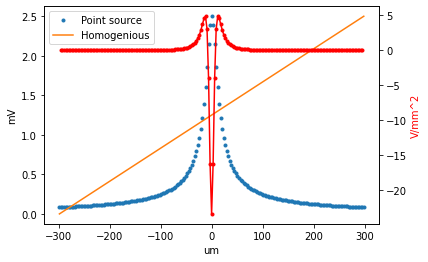

In [13]:
# Point Source
I_ext = 0.01 * uA
rho = 1 / (0.4 * siemens / meter)
dist_y = 10 * um
V_e_pointsource = rho * I_ext / np.sqrt(dist_y**2 + morpho.x**2)
# Homogenious field
V_e_homogenious = np.linspace(0, 2.5, morpho.n) * 1e-3 * volt

# Plot el. Potential
ln = plt.plot(morpho.x / um, V_e_pointsource / mV, ".", label="Point source")
plt.plot(morpho.x / um, V_e_homogenious / mV, label="Homogenious")
plt.ylabel('mV')
plt.xlabel('um')
plt.legend()
# Plot second derivative of el. Potential
plt.twinx()
af = (np.diff(V_e_pointsource, n=2) / (np.diff(morpho.x)[1:])**2)
plt.plot(morpho.x[1:-1] / um, af / (volt / mm**2), ".-", color='red')
plt.ylabel('V/mm^2', color="red")

# Running the Simulation

In [80]:
def runSimulation(V_e,
                  dt=0.001 * ms,
                  method='exponential_euler',
                  gL=1e-15 * siemens / cm**2,
                  space_ax=None,
                  axs=None,
                  **plt_kwargs):
    start_scope()
    defaultclock.dt = dt

    # Define neuron
    EL = 0 * mV
    eqs = '''
    Im = gL * (EL - v) : amp/meter**2
    I : amp (point current)
    '''
    neuron = SpatialNeuron(morphology=morpho,
                           model=eqs,
                           Cm=Cm,
                           Ri=Ri,
                           method=method)
    # Set initial state
    neuron.v = EL

    # Constants neccessary for calculation of the current
    # In principle we can have an inhomogenious cable, then this needs to be changed!
    ri = Ri / neuron.morphology.area[1]
    segment_length = neuron.morphology.length[1]
    E_total = np.zeros(np.shape(V_e)[0] + 1) * mV / mm

    # This is the function that introduces the external field
    @network_operation()  # dt=0.002 * ms)
    def update_active():
        E_m = np.diff(neuron.v, n=1) / (segment_length)
        E_e = np.diff(V_e, n=1) / (segment_length)
        E_total[1:-1] = E_m + E_e
        E_total[0] = 0 * mV / mm
        E_total[-1] = 0 * mV / mm
        dE_total = np.diff(E_total)  # /(mV/mm)

        # Needs some kind of damping (spatial was dismissed intead temporal, below)
        # dE_total = savgol_filter(dE_total, 7, 1)*mV/mm
        dE_total -= np.mean(dE_total)
        
        #######################################################################
        # Here the factor 1.5e-3 is not correct, (otherwise it is not stable..)
        #######################################################################
        # TODO: fix
        I_total = 1.5e-3 * (1 / ri) * length * dE_total / segment_length
        
        #neuron.I = I_total
        neuron.I += (I_total - neuron.I) / 5

    M = StateMonitor(neuron, ('v', 'I'), record=True)

    # Plotting
    if space_ax is None:
        space_fig, space_ax = plt.subplots(1, 1, figsize=(14, 5))  #, sharey="row")
    
    for i in range(3):
        run(.03 * ms)  # , report='text')
        space_ax.plot(neuron.x / um, neuron.v / mV, **plt_kwargs)
    run(0.6 * ms)  # , report='text')
    space_ax.plot(neuron.x / um, neuron.v / mV, "black", **plt_kwargs)
    space_ax.set_xlabel('x (um)')
    space_ax.set_ylabel('v (mV)')

    if axs is None:
        fig, axs = plt.subplots(2, 4, figsize=(14, 5))  #, sharey="row")
        
    for i, ax_a in zip([0, 80, 100, 200], axs.T):
        ax_a[0].plot(M.t / ms, M.v[i] / mV, **plt_kwargs)
        ax_a[1].plot(M.t / ms, M.I[i]/segment_length / (amp/meter), **plt_kwargs)
    axs[0,0].set_ylabel("mV")
    axs[1,0].set_ylabel("A/m")
    axs[1,0].set_xlabel("ms")
    plt.tight_layout()

## Running point source

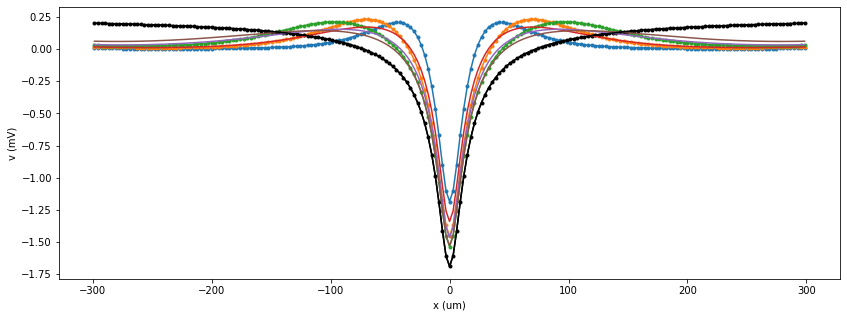

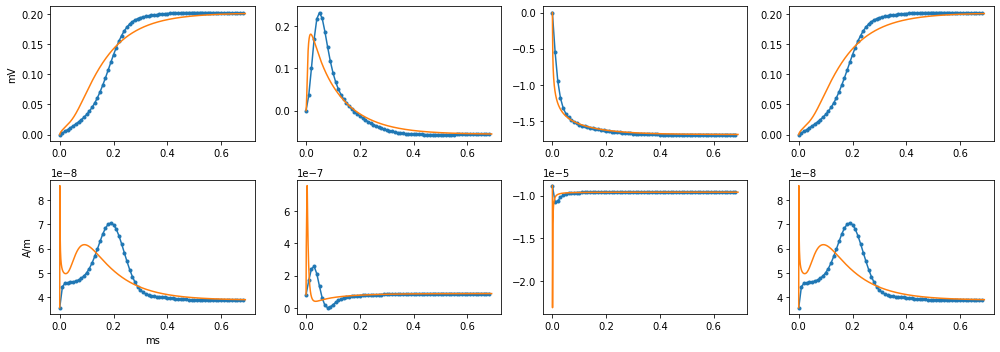

In [81]:
space_fig, space_ax = plt.subplots(1, 1, figsize=(14, 5))  #, sharey="row")
fig, axs = plt.subplots(2, 4, figsize=(14, 5))  #, sharey="row")

# rk4 RungeKutta is probably a good choice
# gsl_rk4 has an adapting Timestep

runSimulation(V_e=V_e_pointsource,
              axs=axs,
              space_ax=space_ax,
              dt=0.01 * ms,
              method="rk4",
              marker=".")

# Smaller step size
runSimulation(V_e=V_e_pointsource,
              axs=axs,
              space_ax=space_ax,
              dt=0.0001 * ms,
              method="rk4")

## Running homogenious field

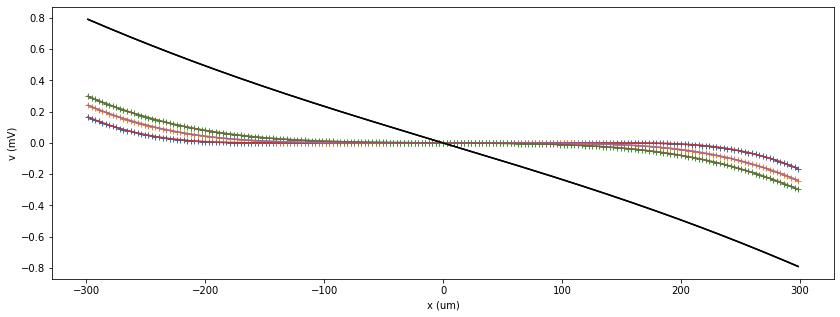

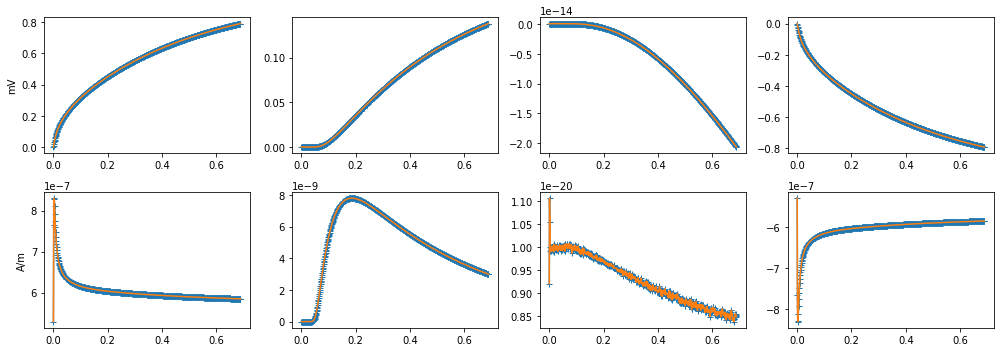

In [67]:
space_fig, space_ax = plt.subplots(1, 1, figsize=(14, 5))  #, sharey="row")
fig, axs = plt.subplots(2, 4, figsize=(14, 5))  #, sharey="row")
runSimulation(V_e=V_e_homogenious, space_ax=space_ax, axs=axs, marker="+")
runSimulation(V_e=V_e_homogenious, space_ax=space_ax, axs=axs, method="gsl_rk4")